# CreditCardApproval EDA Diana Max

## Setup notebook & fetch data

In [2]:
from ucimlrepo import fetch_ucirepo
#from ydata_profiling import ProfileReport

import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.contingency import association
from scipy.stats import pointbiserialr, pearsonr, spearmanr

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, FunctionTransformer, LabelBinarizer, label_binarize, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [3]:
credit_approval = fetch_ucirepo(id=27)

X = credit_approval.data.features
y = credit_approval.data.targets
df = credit_approval.data.original

## First look

In [4]:
credit_approval.data.original

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260.0,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200.0,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200.0,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280.0,750,-


In [5]:
# ProfileReport(df)

## Univariate EDA

### A1

[Text(0, 0.5, 'value count')]

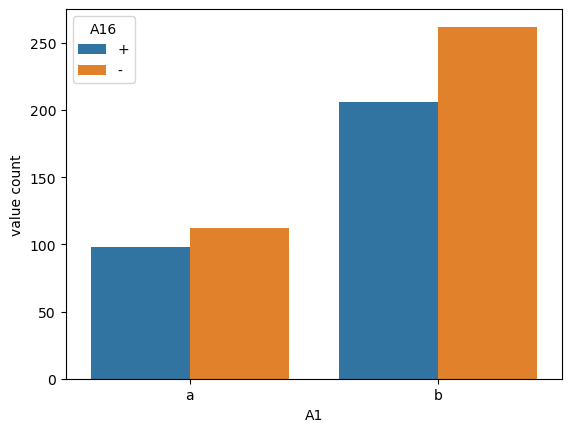

In [6]:
A1 = df[['A1','A16']]

ax = sns.barplot(
    data=A1.reset_index().groupby(['A1','A16']).count().reset_index(),
    x='A1',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

In [7]:
df.A1.isna().sum()

12

Impute missing values with most frequent category.

### A2

<Axes: xlabel='A2', ylabel='Density'>

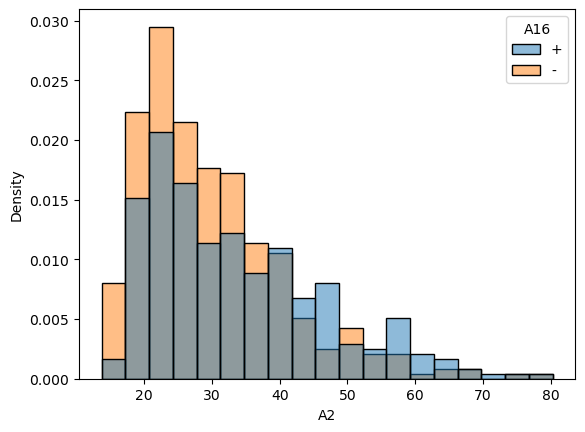

In [8]:
A2 = df[['A2','A16']]
sns.histplot(A2, x='A2', hue='A16',stat='density')

Let's try a log1p transform.

<Axes: xlabel='A2', ylabel='Density'>

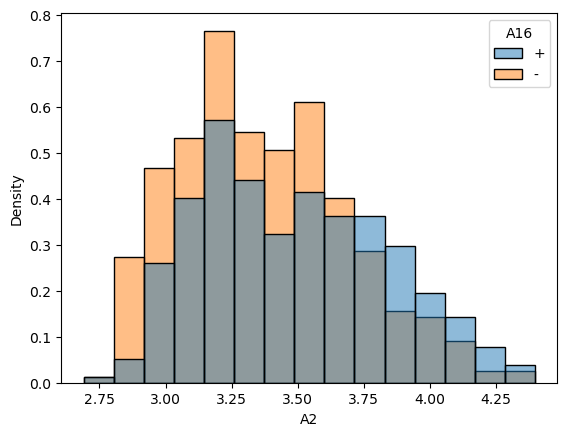

In [9]:
A2 = A2.assign(A2=A2.A2.apply(np.log1p))
sns.histplot(A2, x='A2', hue='A16',stat='density')

The distribution is less skewed now, so it seems like a usefull transformation.

In [10]:
df.A2.isna().sum()

12

Its still skewed, so impute missing values with median.

### A3

<Axes: xlabel='A3', ylabel='Density'>

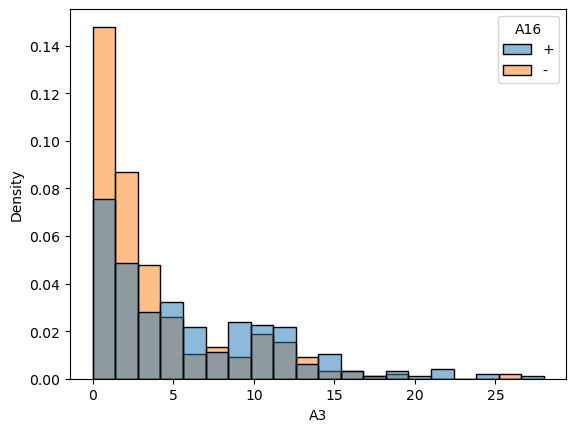

In [11]:
A3 = df[['A3','A16']]
sns.histplot(A3, x='A3', hue='A16',stat='density')

Let's try a log1p transform.

<Axes: xlabel='A3', ylabel='Density'>

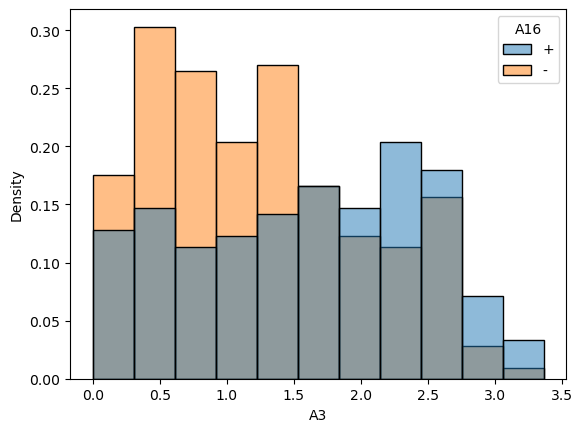

In [12]:
A3 = A3.assign(A3=A3.A3.apply(np.log1p))
sns.histplot(A3, x='A3', hue='A16',stat='density')

The distribution is much less skewed now. Looks like a very good option.

In [13]:
df.A3.isna().sum()

0

Its still skewed, so impute missing values with median.

### A4

[Text(0, 0.5, 'value count')]

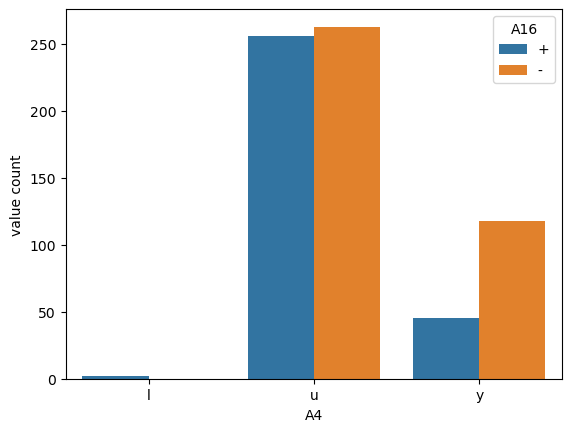

In [14]:
A4 = df[['A4','A16']]

ax = sns.barplot(
    data=A4.reset_index().groupby(['A4','A16']).count().reset_index(),
    x='A4',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Bin categories to u and non-u.

In [15]:
df.A4.isna().sum()

6

Replace missing values with the most-frequent category.

### A5

[Text(0, 0.5, 'value count')]

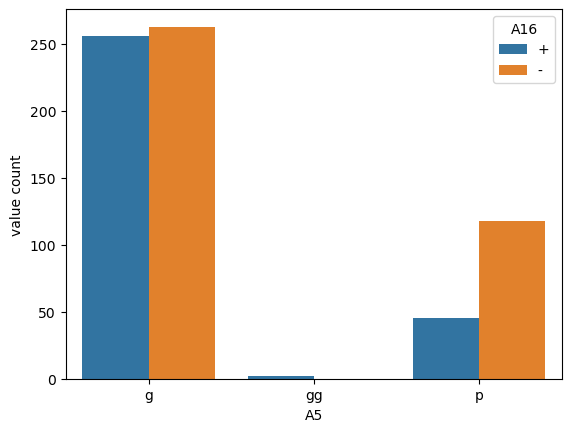

In [16]:
A5 = df[['A5','A16']]

ax = sns.barplot(
    data=A5.reset_index().groupby(['A5','A16']).count().reset_index(),
    x='A5',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Bin categories to g and non-g.

Replace missing values with the most-frequent category.

### A6

[Text(0, 0.5, 'value count')]

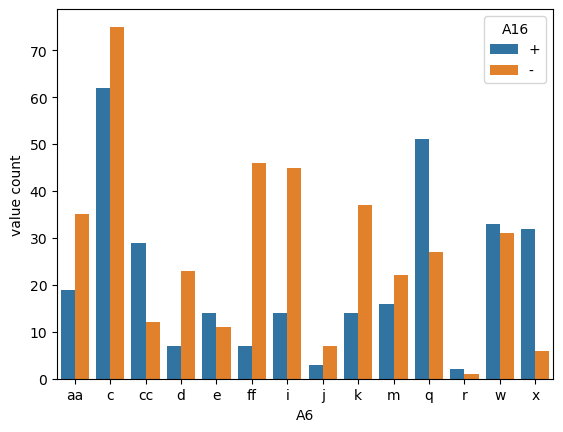

In [17]:
ax = sns.barplot(
    data=df.reset_index().groupby(['A6','A16']).count().reset_index(),
    x='A6',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Many categories with quite a range of different distributions of A16 (target) values. Target encoding seems like a reasonable choice.

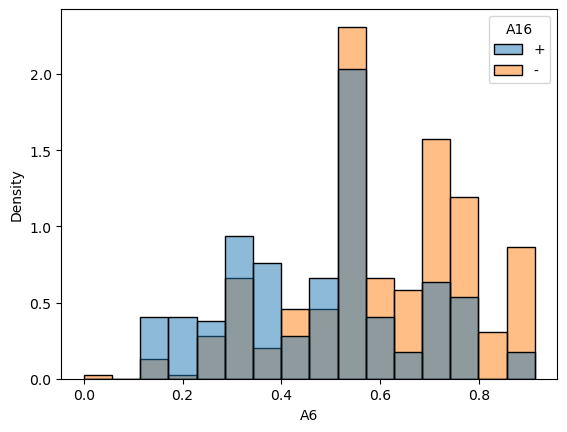

In [18]:
ax = sns.histplot(
    data= pd.DataFrame({
        'A6': TargetEncoder().fit_transform(df.A6.values[:,np.newaxis], df.A16).ravel(),
        'A16': df.A16.values}),
    x='A6',
    hue='A16',
    stat='density'
)

Target encoding looks promising.

In [19]:
df.A6.isna().sum()

9

Impute with median.

### A7

[Text(0, 0.5, 'value count')]

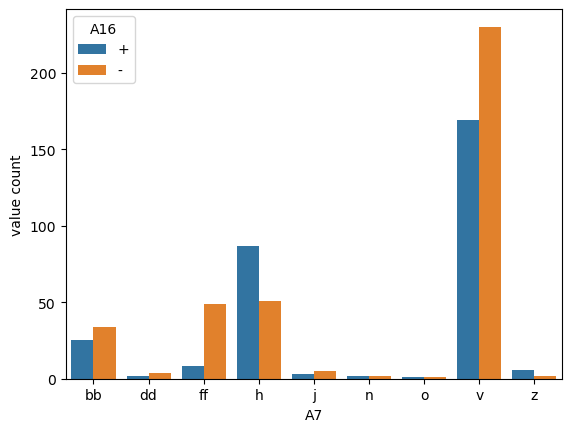

In [20]:
ax = sns.barplot(
    data=df.reset_index().groupby(['A7','A16']).count().reset_index(),
    x='A7',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Naively try target encoding first.

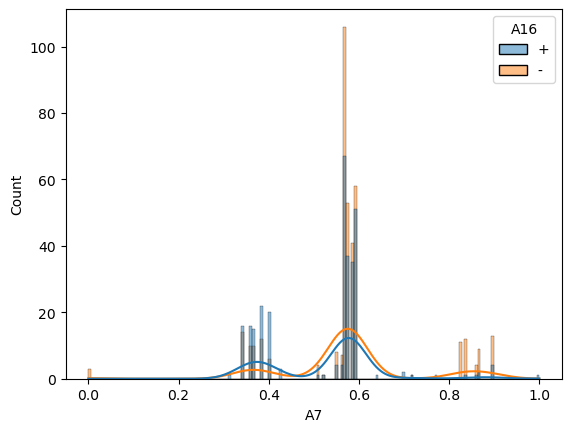

In [21]:
ax = sns.histplot(
    data= pd.DataFrame({
        'A7': TargetEncoder().fit_transform(df.A7.values[:,np.newaxis], df.A16).ravel(),
        'A16': df.A16.values}),
    x='A7',
    hue='A16',
    kde=True
)

This looks not quite usefull yet, as the kernel density estimates show curves of almost the same shape and location.

Many categories with almost no values. Summarising those categories, that have similar distributions of A16, so: (v, dd, j), (h, z), (bb, n, o), (ff), could be an option.

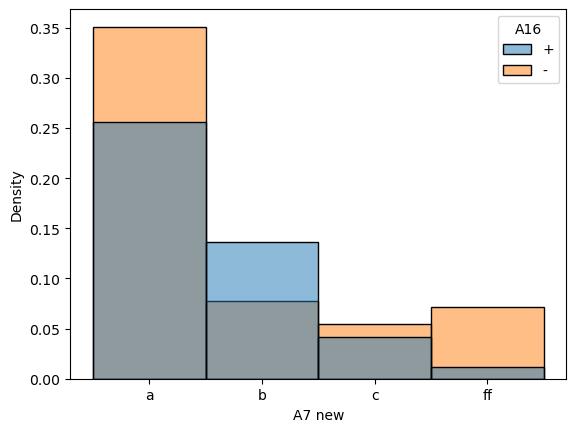

In [22]:
ax = sns.histplot(
    data=pd.DataFrame({
        'A7 new': df.A7.replace({'v':'a','dd':'a','j':'a',  'h':'b','z':'b', 'bb':'c','n':'c','o':'c'}).ravel(),
        'A16': df.A16.values}),
    x='A7 new',
    hue='A16',
    stat='density'
)

This still doesnt look very usefull, suggesting either the features is generally bad (at least for a linear classifier) or the new categories are bad.

We will come back to this feature later on. We will have a look at correlations and mutual information first to get a little more information about this feature. If it contians high information, OneHot encoding might be worth it (as it adds dimensions but this might be worth for a good feature).


Otherwise we might try other binnings of categories or throw the feature out all toghether.

In [23]:
df.A7.isna().sum()

9

Impute missing values with median.

### A8

<Axes: xlabel='A8', ylabel='Density'>

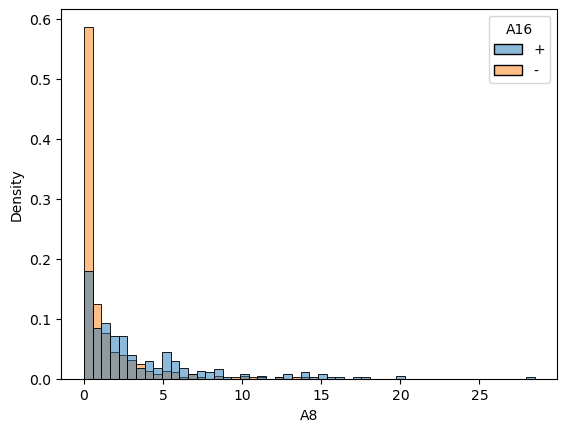

In [24]:
A8 = df[['A8','A16']]
sns.histplot(A8, x='A8', hue='A16',stat='density')

Try a log1p transform.

<Axes: xlabel='A8', ylabel='Density'>

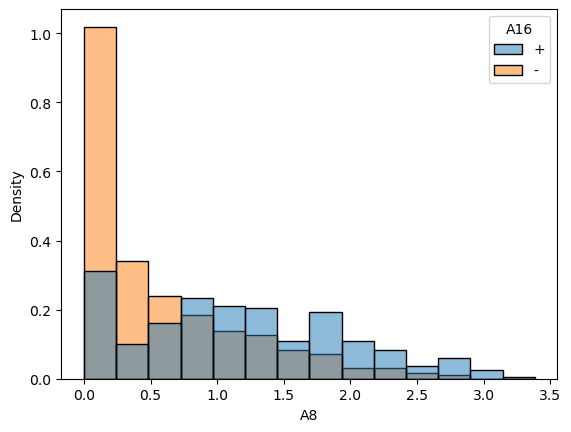

In [25]:
A8 = A8.assign(A8=A8.A8.apply(np.log1p))
sns.histplot(A8, x='A8', hue='A16',stat='density')

Although this already looks quite promising a common logarithm (base = 10) might be even better, as the distribution is still strongly left skewed.

<Axes: xlabel='A8', ylabel='Density'>

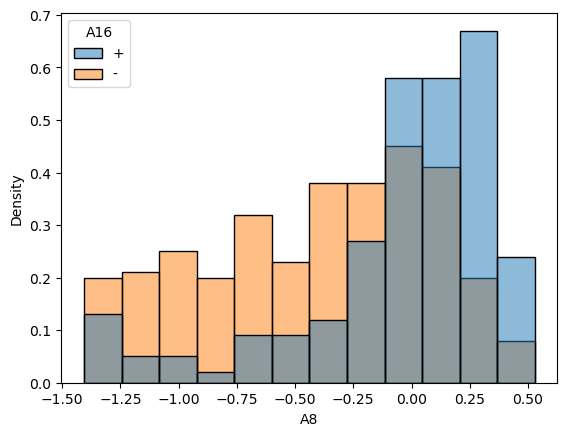

In [26]:
A8 = A8.assign(A8=A8.A8.apply(np.log10))
sns.histplot(A8, x='A8', hue='A16',stat='density')

Looks reasonably well.

In [27]:
df.A8.isna().sum()

0

No missing values.

### A9

[Text(0, 0.5, 'value count')]

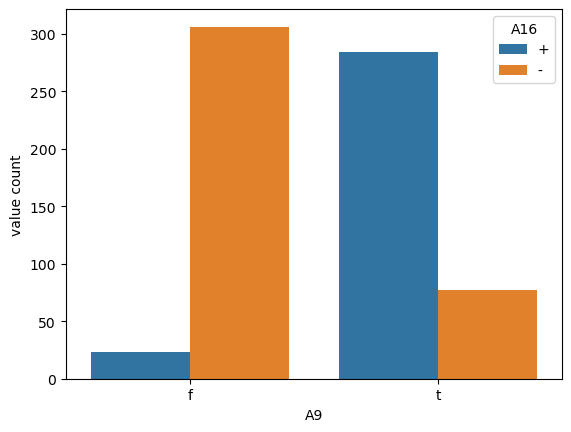

In [28]:
A9 = df[['A9','A16']]

ax = sns.barplot(
    data=A9.reset_index().groupby(['A9','A16']).count().reset_index(),
    x='A9',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

In [29]:
df.A9.isna().sum()

0

Feature is already in binary format and doesn't have any missing values. Perfect.

### A10

[Text(0, 0.5, 'value count')]

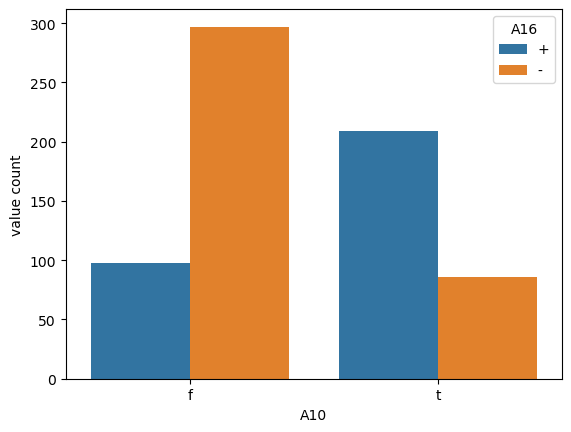

In [30]:
A10 = df[['A10','A16']]

ax = sns.barplot(
    data=A10.reset_index().groupby(['A10','A16']).count().reset_index(),
    x='A10',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

In [31]:
df.A10.isna().sum()

0

Feature is already in binary format and doesn't have any missing values. Perfect.

### A11

<Axes: xlabel='A11', ylabel='Count'>

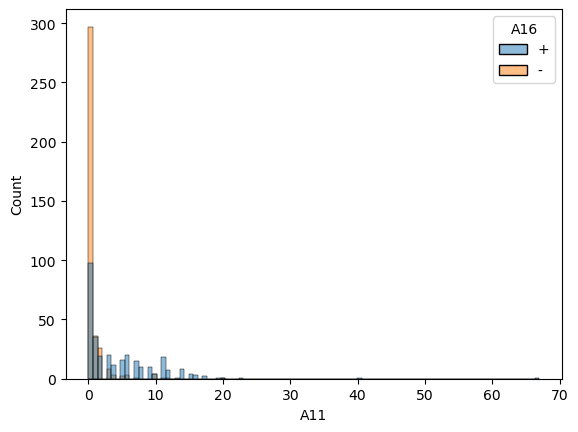

In [32]:
A11 = df[['A11','A16']]
sns.histplot(A11, x='A11', hue='A16')

Extremely strong left-skewed distribution with mostly Zeros. Apply a log1p transform.

<Axes: xlabel='A11', ylabel='Count'>

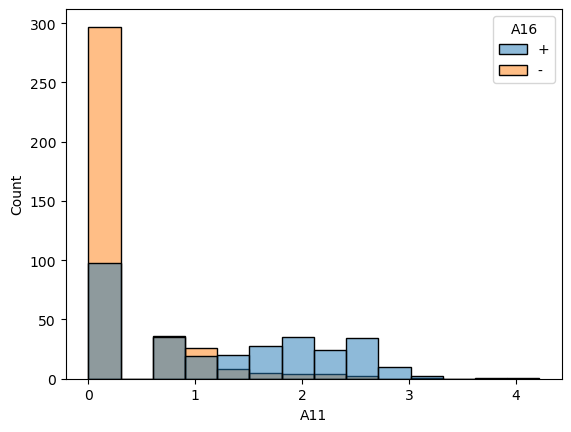

In [33]:
A11 = A11.assign(A11=A11.A11.apply(np.log1p))
sns.histplot(A11, x='A11', hue='A16')

This looks much better.

In [34]:
df.A11.isna().sum()

0

### A12

[Text(0, 0.5, 'value count')]

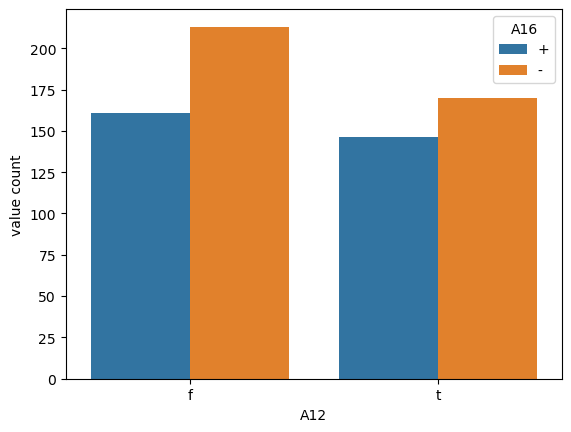

In [35]:
A12 = df[['A12','A16']]

ax = sns.barplot(
    data=A12.reset_index().groupby(['A12','A16']).count().reset_index(),
    x='A12',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

In [36]:
df.A12.isna().sum()

0

Feature is already in binary format and doesn't have any missing values. Perfect.

### A13

[Text(0, 0.5, 'value count')]

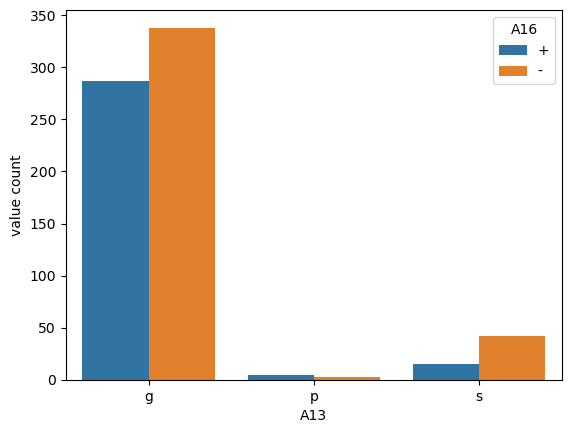

In [37]:
A13 = df[['A13','A16']]

ax = sns.barplot(
    data=A13.reset_index().groupby(['A13','A16']).count().reset_index(),
    x='A13',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Binarise. Since the distirbution of A16 among p resembles more that of g, summarise g and p into one category.

In [38]:
df.A13.isna().sum()

0

No missing values.

### A14

<Axes: xlabel='A14', ylabel='Count'>

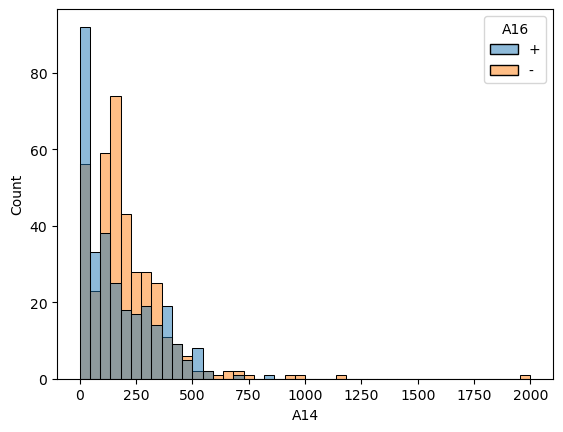

In [39]:
A14 = df[['A14','A16']]
sns.histplot(A14, x='A14', hue='A16')

Strongly left-skewed, apply log1p transform.

<Axes: xlabel='A14', ylabel='Count'>

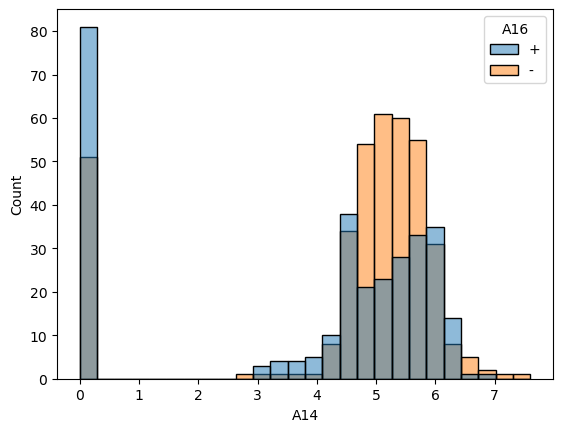

In [40]:
A14 = A14.assign(A14=A14.A14.apply(np.log1p))
sns.histplot(A14, x='A14', hue='A16')

Fine.

In [41]:
df.A14.isna().sum()

13

Impute missing values with most frequent value, Zero, which is reasonably well balanced between values for the target.

### A15

<Axes: xlabel='A15', ylabel='Count'>

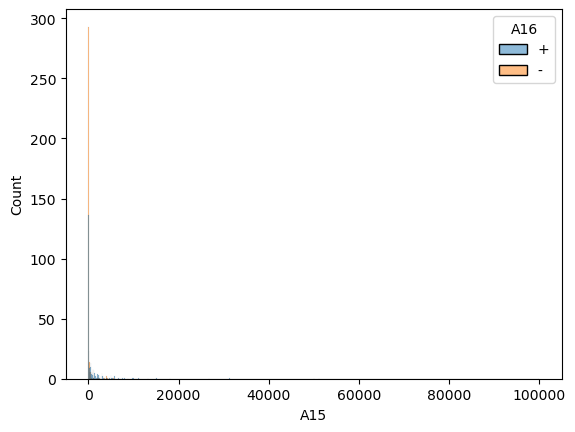

In [42]:
A15 = df[['A15','A16']]
sns.histplot(A15, x='A15', hue='A16')

Apply a log1p transform.

<Axes: xlabel='A15', ylabel='Count'>

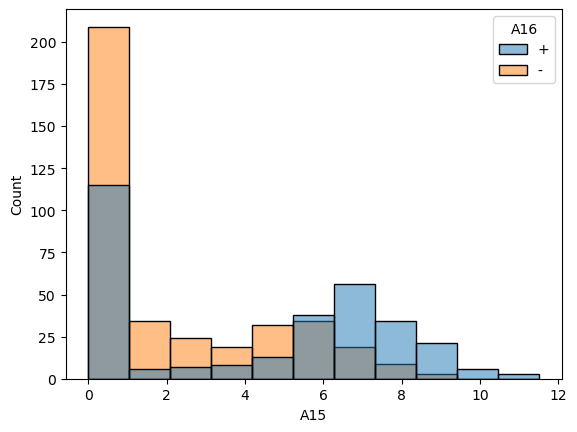

In [43]:
A15 = A15.assign(A15=A15.A15.apply(np.log1p))
sns.histplot(A15, x='A15', hue='A16')

Looks much better. Keep that.

In [44]:
df.A15.isna().sum()

0

No missing values.

### A16

In [45]:
df.A16.value_counts()

A16
-    383
+    307
Name: count, dtype: int64

## Multivariate EDA

### NaN Analysis

In [46]:
credit_approval.variables[['name','missing_values']]

,name,missing_values
0,A16,no
1,A15,no
2,A14,yes
3,A13,no
4,A12,no
5,A11,no
6,A10,no
7,A9,no
8,A8,no
9,A7,yes


In [47]:
df.isna()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
686,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
687,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
688,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [48]:
df.isna().any(axis=1).sum() / df.shape[0]

0.0536231884057971

About 5% of the data contains missing values.

TODO: look if some features are always NaN at the same time

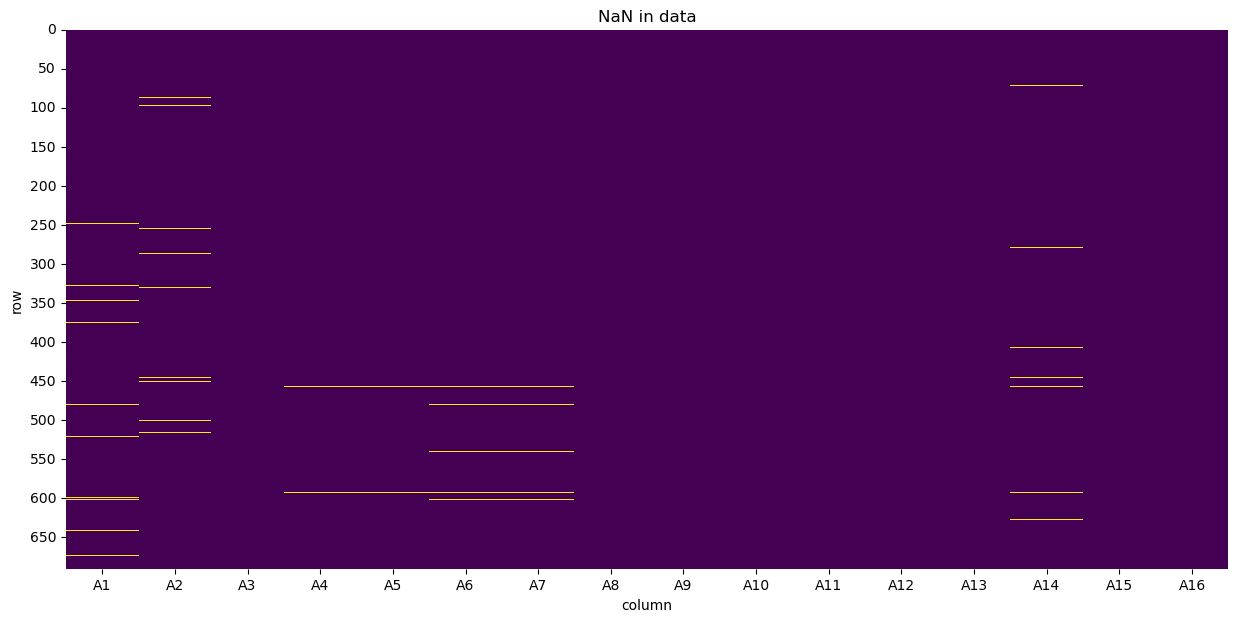

In [103]:

# df, wo nan True ist
nan_matrix = df.isna()

# heatmap
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(nan_matrix, cbar=False, cmap="viridis", ax=ax)

plt.title('NaN in data')
plt.xlabel('column')
plt.ylabel('row')

start, end = ax.get_xlim()
ax.yaxis.set_ticks(np.arange(0, 690, 50))
ax.set_yticklabels(np.arange(0, 690, 50))
plt.show()

### Correlations with target

Correlate every variables with target:
- categorical data: Cramers V
- continuous data: Point biserial correlation

#### categorical

<Axes: >

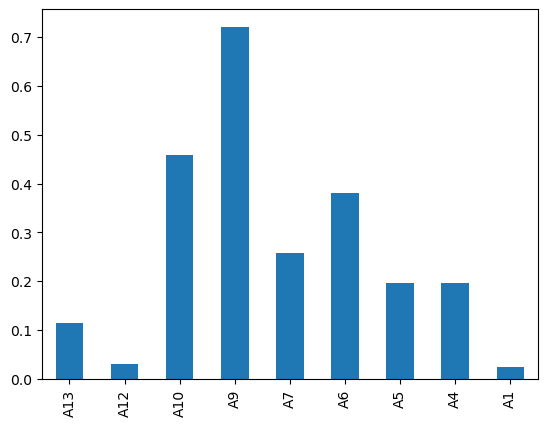

In [50]:
categorical_variables = credit_approval.variables[(credit_approval.variables.type == 'Categorical') & (credit_approval.variables.role == 'Feature')].name.values
s = pd.Series(index=categorical_variables)


for var in categorical_variables:
    s[var] = association(pd.crosstab(df[var], df.A16))

s.plot(kind='bar')

#### continuous

<Axes: >

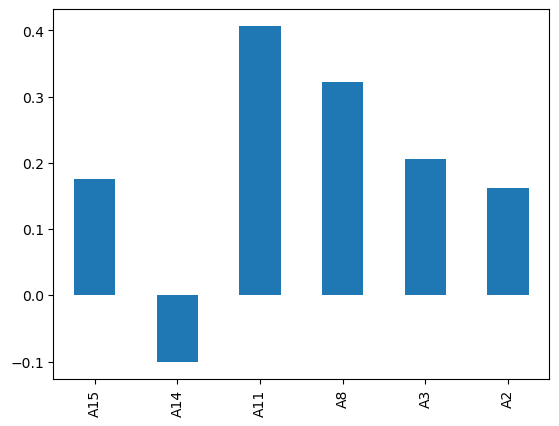

In [51]:
target = y.replace({'+':1,'-':0})

continuous_variables = credit_approval.variables[(credit_approval.variables.type == 'Continuous') & (credit_approval.variables.role == 'Feature')].name.values

s = pd.Series(index=continuous_variables)


for var in continuous_variables:
    s[var] = pointbiserialr(target[~df[var].isna()].values.ravel(), df[var].dropna().values).statistic

s.plot(kind='bar')

### Correlations and mutual information between variables

In [52]:
"""
Compute mutual information in every commbination of two variables. We don't use product-momment or rank correlation since it assumes at least a monotonic relationship, which is a assumption we don't want to make at this point.

- Cramer's V for all combinations of categorical variables
- Pearson and Spearman for all combinations of continuous variables

- Mutal information for every combination of variables.

"""

"\nCompute mutual information in every commbination of two variables. We don't use product-momment or rank correlation since it assumes at least a monotonic relationship, which is a assumption we don't want to make at this point.\n\n- Cramer's V for all combinations of categorical variables\n- Pearson and Spearman for all combinations of continuous variables\n\n- Mutal information for every combination of variables.\n\n"

In [53]:
category = credit_approval.variables[['name','type']].set_index('name')

#### Between categorical variables
Cramer's V

Text(0.5, 1.0, 'Cramer´s V')

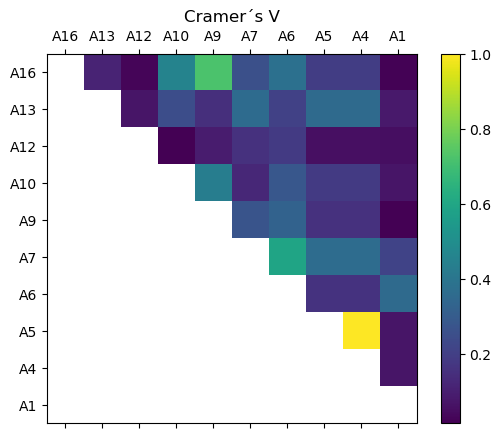

In [54]:
vars_cat    = category[category.type == 'Categorical'].index
n_cat       = len(vars_cat)
cramers_mat = pd.DataFrame(index=vars_cat, columns=vars_cat, dtype=np.float64)

for var1, var2 in itertools.combinations(vars_cat, r=2):
    cramers_mat.loc[var1,var2] = association(pd.crosstab(df[var1], df[var2]))

fig, ax = plt.subplots()
axi = ax.matshow(cramers_mat)
ax.set_xticks(range(n_cat), labels=vars_cat)
ax.set_yticks(range(n_cat), labels=vars_cat)

plt.colorbar(axi, ax=ax)
plt.title('Cramer´s V')

#### Between continuous variables

In [55]:
vars_con    = category[category.type == 'Continuous'].index
n_con       = len(vars_con)

pearson_mat = pd.DataFrame(index=vars_con, columns=vars_con, dtype=np.float64)
spearman_mat = pd.DataFrame(index=vars_con, columns=vars_con, dtype=np.float64)


#### Pearson product-moment correlation coefficient

Text(0.5, 1.0, 'Pearson product-moment correlation coefficient')

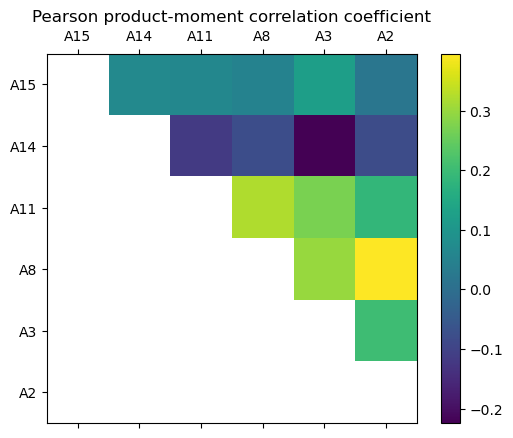

In [56]:
for var1, var2 in itertools.combinations(vars_con, r=2):
    
    pearson_mat.loc[var1,var2] =  pearsonr(
        df[[var1,var2]].dropna(how='any')[var1],
        df[[var1,var2]].dropna(how='any')[var2]).statistic

fig, ax = plt.subplots()
axi = ax.matshow(pearson_mat)
ax.set_xticks(range(n_con), labels=vars_con)
ax.set_yticks(range(n_con), labels=vars_con)

plt.colorbar(axi, ax=ax)
plt.title('Pearson product-moment correlation coefficient')

#### Spearman rank correlation coefficient

Text(0.5, 1.0, 'Spearman rank correlation coefficient')

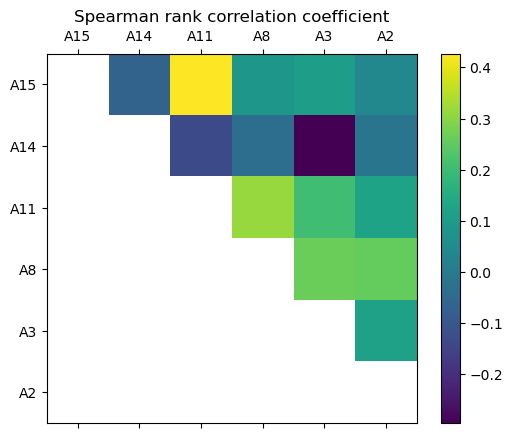

In [57]:
for var1, var2 in itertools.combinations(vars_con, r=2):
    
    spearman_mat.loc[var1,var2] =  spearmanr(
        df[[var1,var2]].dropna(how='any')[var1],
        df[[var1,var2]].dropna(how='any')[var2]).statistic

fig, ax = plt.subplots()
axi = ax.matshow(spearman_mat)
ax.set_xticks(range(n_con), labels=vars_con)
ax.set_yticks(range(n_con), labels=vars_con)

plt.colorbar(axi, ax=ax)
plt.title('Spearman rank correlation coefficient')

#### Mutual information (combinations of categorical and continuous)

In this context, there is no reasonable way known to the authers to correlate a multi-class (k > 2) categorical variable to a continuous variable.

- Therefore, we already do some tweaking of the data here, applying reasonable ways to allow us to correlate as many features as possible. Namely: Make A4, A5 and A13 binary variables by by summarising classes.

- Also, we apply the log transform to features with a strongly skewed distribution (A3, A8, A11, A14, A15) already, to make the correlations more meaningfull, since we are not (!) doing rank correlations.

- A obvious way to deal with A6 and A7 is target encoding, we will also already apply that here, for the sake of not leaving A6 and A7 completely out of the feature-feature correlations. This is however still EDA and not the feature engineering part.

- Since only 5% of the data contains missing values, we will for now throw out any column that has missing values.

In [58]:
column_tweaker = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='first'),
        ['A1','A9','A10','A12','A16']
    ),
    (
        FunctionTransformer(lambda col: label_binarize(col, classes=['u'])),
        ['A4']
    ),
    (
        FunctionTransformer(lambda col: label_binarize(col, classes=['g'])),
        ['A5']
    ),
    (
        # becoming numeric column
        TargetEncoder(),
        ['A6', 'A7']
    ),
    (
        FunctionTransformer(lambda col: label_binarize(col, classes=['g'])),
        ['A13']
    ),
    (
        FunctionTransformer(np.log1p),
        ['A2','A3','A8','A11','A14','A15']
    ),

    # leave everything else untouched
    remainder='drop'
)

df_tweaked = df.copy(deep=True).dropna(how='any')
var_names = df.columns

df_tweaked = pd.DataFrame(column_tweaker.fit_transform(df_tweaked, y=df_tweaked.A16), columns=['A1','A9','A10','A12' ,'A16','A4','A5','A6','A7','A13','A2','A3','A8','A11','A14','A15'])
df_tweaked = df_tweaked[var_names] # bring columns in right order again

category = credit_approval.variables[['name','type']].set_index('name')
category.loc[['A6','A7'],:] = 'Continuous'

df_tweaked.head(7)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1.0,3.460409,0.000000,1.0,1.0,0.519756,0.572733,0.810930,1.0,1.0,0.693147,0.0,1.0,5.313206,0.000000,0.0
1,0.0,4.088829,1.697449,1.0,1.0,0.435163,0.381912,1.396245,1.0,1.0,1.945910,0.0,1.0,3.784190,6.329721,0.0
2,0.0,3.238678,0.405465,1.0,1.0,0.347243,0.351957,0.916291,1.0,0.0,0.000000,0.0,1.0,5.638355,6.715383,0.0
3,1.0,3.361417,0.932164,1.0,1.0,0.541773,0.580426,1.558145,1.0,1.0,1.791759,1.0,1.0,4.615121,1.386294,0.0
4,1.0,3.052585,1.890850,1.0,1.0,0.519756,0.572733,0.996949,1.0,0.0,0.000000,0.0,0.0,4.795791,0.000000,0.0
5,1.0,3.498929,1.609438,1.0,1.0,0.604381,0.572733,1.252763,1.0,0.0,0.000000,1.0,1.0,5.888878,0.000000,0.0
6,1.0,3.531348,0.712950,1.0,1.0,0.515413,0.373123,2.014903,1.0,0.0,0.000000,1.0,1.0,5.105945,10.350926,0.0


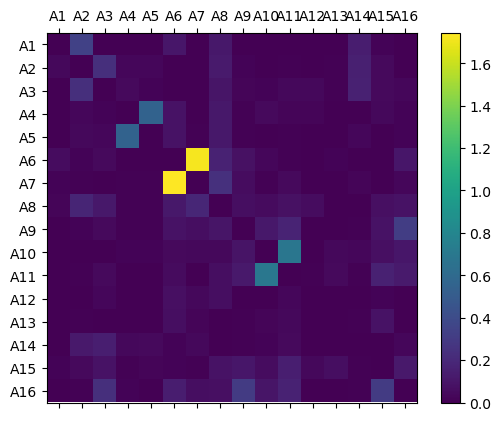

In [59]:
warnings.simplefilter('ignore', UserWarning)

mutual_informaion = pd.DataFrame(index=var_names, columns=var_names)

# each variable is taken as target variable
for var in var_names:
    
    discrete_features_mask = (category.loc[category.index!=var,:] == 'Categorical').values.ravel()
    
    # use mutual_info_regression if targeted variable is continuous
    if category.loc[var][0] == 'Continuous':
        mutual_informaion.loc[var, var_names != var] = mutual_info_regression(
            df_tweaked.loc[:, df_tweaked.columns != var],
            df_tweaked[var],
            discrete_features=discrete_features_mask
        )

    # use mutual_info_regression if targeted variable is categorical
    if category.loc[var][0] == 'Categorical':
        mutual_informaion.loc[var, var_names != var] = mutual_info_classif(
            df_tweaked.loc[:, df_tweaked.columns != var],
            df_tweaked[var],
            discrete_features=discrete_features_mask
        )
mutual_informaion = mutual_informaion.fillna(0)

fig, ax = plt.subplots()
axi = ax.matshow(mutual_informaion)
ax.set_xticks(range(len(var_names)), labels=var_names)
ax.set_yticks(range(len(var_names)), labels=var_names)

plt.colorbar(axi, ax=ax);

### Determining clustering for A7

Principal component analysis allows us to project data into a 2D space, where we can visualise it.

We wanted to summarize categories for A7, since we don't have any semantic information on the categories but still want a way to figure out, which categories to group together we can try to utilise PCA.


If we project the data, we can visually inspect, if there are any clusters which suggest a possible grouping of A7's categories.

We try PCA for differet sets of features and selectively in combination with the target.

#### Set up PCA for projection into 2D space

In [60]:
X_tweaked = df_tweaked.iloc[:,:15]
y_tweaked = pd.DataFrame(df_tweaked.A16)

In [61]:
X_tweaked_train, X_tweaked_test, y_tweaked_train, y_tweaked_test = train_test_split(X_tweaked, y_tweaked, test_size=.1)

In [62]:
pca = make_pipeline(
    MinMaxScaler(),
    PCA(n_components=2,svd_solver='full')
)
pca

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('pca', PCA(n_components=2, svd_solver='full'))])

#### Features and target

<Axes: xlabel='x', ylabel='y'>

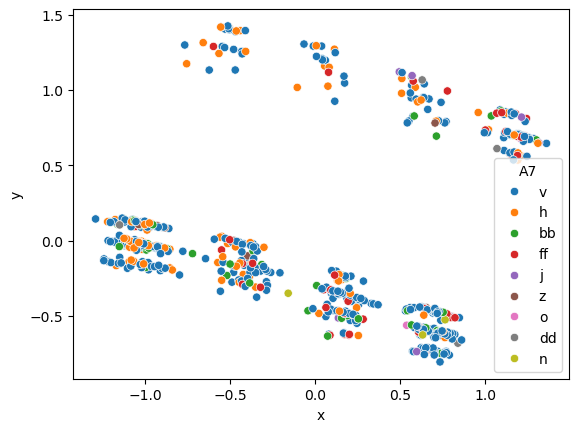

In [63]:
res = pd.DataFrame(pca.fit_transform(df_tweaked), columns = ['x','y'])
sns.scatterplot(res, x='x', y='y', hue=df.A7)

#### Feature space only

<Axes: xlabel='x', ylabel='y'>

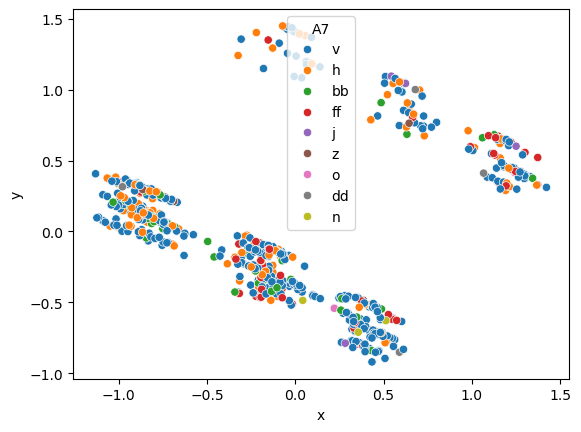

In [64]:
res = pd.DataFrame(pca.fit_transform(X_tweaked), columns = ['x','y'])
sns.scatterplot(res, x='x', y='y', hue=df.A7)

#### exclude A7

<Axes: xlabel='x', ylabel='y'>

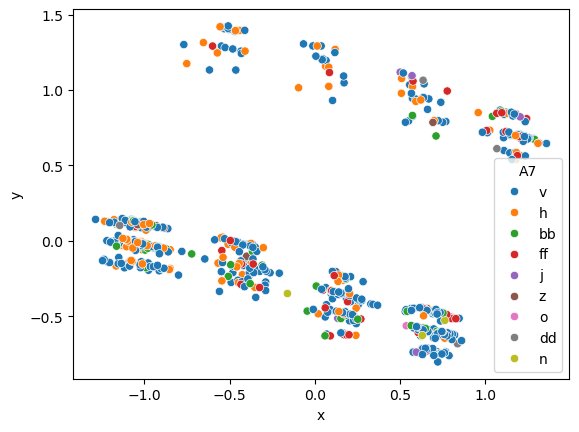

In [65]:
df_a7=df_tweaked.loc[:,df_tweaked.columns!='A7']

res = pd.DataFrame(pca.fit_transform(df_a7), columns = ['x','y'])
sns.scatterplot(res, x='x', y='y', hue=df.A7)

#### Result

There are no obvious visible clusters resulting.

## Feature space PCA 

To further improve our understanding of the dataset, we again perform a PCA.

This time we want to look into how many principal components our feature space will be decomposed and how much varaince each of these components is explaining.

This is done to get a idea of the dimensionality of the data, which will further our understanding of the dataset, will be usefull when deciding how much PCA to perform during feature engingeering and to already get a idea of what classifiers we might use later on, as different classifiers show different effectivity with high or low dimensional data. 

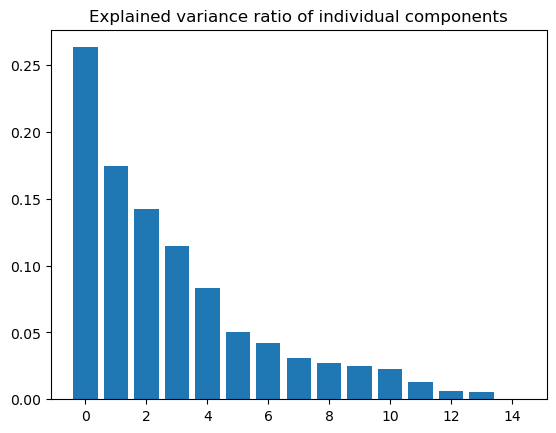

In [66]:
pca = make_pipeline(
    MinMaxScaler(),
    PCA(svd_solver='full')
)
pca

res = pca.fit(X_tweaked).transform(X_tweaked)

plt.bar(range(len(pca['pca'].explained_variance_ratio_)), pca['pca'].explained_variance_ratio_)
plt.title('Explained variance ratio of individual components');

array([0.26, 0.44, 0.58, 0.69, 0.78, 0.83, 0.87, 0.9 , 0.93, 0.95, 0.98,
       0.99, 0.99, 1.  , 1.  ])

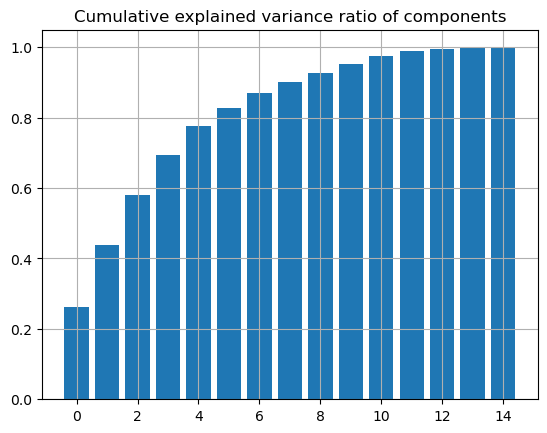

In [67]:
plt.bar(range(len(pca['pca'].explained_variance_ratio_)), np.cumsum(pca['pca'].explained_variance_ratio_))
plt.title('Cumulative explained variance ratio of components');
plt.grid();
np.round(np.cumsum(pca['pca'].explained_variance_ratio_),2)

We already explain 80% of the variance with 4 components and around 99% with 12 components.

## Conclusions

### A4 & A5

A4 and A5 have a correlation coefficient of 1. Therefore they are identical and one of them can instantly be discarded from the dataset (we discard A5).

### A7

In [68]:
cramers_mat.loc['A7','A6']

0.5896455216352515

In [69]:
mutual_informaion.loc['A7','A6']

1.7429975716410109

How to deal with A7 ?

A categorical feature with 9 categories. Target encoding didn't bring very promising univariate results even after summarizing from 9 to 3 categories.


However, we also found A7 to only have a medium correlation with the target variable in comparison to the other features and shares a relatively high ammount of mutual information with A6.

Therefore it seems like a reasonable option either just keep the not very promising looking target encoding, as to only add one dimension through this feature, or leave it out all together (which feature selection should do automaticly if our univariate observations also apply in combination with the other features).

In [70]:
strat = pd.DataFrame(index=df.columns, columns=['tweaking','imputation'], data= " ")

strat.loc['A1','tweaking'] = 'OneHotEncoding'
strat.loc['A1','imputation'] = 'MostFrequent category'

#strat.loc['A1','tweaking'] = 'OneHotEncoding'

strat

,tweaking,imputation
A1,OneHotEncoding,MostFrequent category
A2,,
A3,,
A4,,
A5,,
A6,,
A7,,
A8,,
A9,,
A10,,
